# 영화리뷰 실습

Subword(내부단어)
* FastText에서 학습하지 않은 oov때문에 사용
* google wordpiece와 개념 유사

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model

import tensorflow_datasets as tfds

tf.random.set_seed(42)

In [3]:
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXELZPX/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXELZPX/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteXELZPX/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_data, test_data = imdb['train'], imdb['test']

In [5]:
#imdb data로 subwords로 나눈 것
#_: 독립적인 것, br: 뭔가에 붙어서 나오는 것
tokenizer = info.features['text'].encoder
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [6]:
len(tokenizer.subwords)

7928

In [9]:
sample_string = 'Tensorflow, from basics to mastery'

#encode 암호화: raw -> 다른 형태로 변환; sample string -> index
tokenized_string = tokenizer.encode(sample_string)
tokenized_string #각 단어에 대한 index 값
#단어 5개인데 왜 인덱스 10개??

[6307, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]

In [10]:
#기존 영화리뷰 단어에서 tensorflow는 못본단어(oov) - ten, sor, flow는 이미 학습해서 그걸로 나누는 것
#mastery -> master: oov보다는 master로 자르는게 성능 더 좋아짐
for token in tokenized_string:
  print("{} -> {}".format(token, tokenizer.decode([token])))

6307 -> Ten
2327 -> sor
2934 -> flow
2 -> , 
48 -> from 
4249 -> basi
4429 -> cs 
7 -> to 
2652 -> master
8050 -> y


In [11]:
#sample string을 원본으로 붙여줌(decode 복호화)
original_string = tokenizer.decode(tokenized_string)
original_string

'Tensorflow, from basics to mastery'

In [12]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [17]:
#model 학습
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

embedding_dim = 16
max_length = 120

model = Sequential()
model.add(Embedding(tokenizer.vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #긍부정 중 하나 맞히는 것: 이진은 'sigmoid
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           130960    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 131,069
Trainable params: 131,069
Non-trainable params: 0
_________________________________________________________________


In [18]:
tokenizer.vocab_size

8185

In [19]:
num_epochs = 10

#dataset 안에 데이터와 라벨 있는 것
#성능 계속 좋아짐
hist = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 9s 21ms/step - loss: 0.6913 - accuracy: 0.5406 - val_loss: 0.6851 - val_accuracy: 0.5602
Epoch 2/10
391/391 [==============================] - 11s 27ms/step - loss: 0.6437 - accuracy: 0.7153 - val_loss: 0.5943 - val_accuracy: 0.7119
Epoch 3/10
391/391 [==============================] - 12s 30ms/step - loss: 0.5194 - accuracy: 0.8068 - val_loss: 0.4788 - val_accuracy: 0.8194
Epoch 4/10
391/391 [==============================] - 11s 28ms/step - loss: 0.4173 - accuracy: 0.8542 - val_loss: 0.4119 - val_accuracy: 0.8436
Epoch 5/10
391/391 [==============================] - 9s 21ms/step - loss: 0.3523 - accuracy: 0.8796 - val_loss: 0.3685 - val_accuracy: 0.8615
Epoch 6/10
391/391 [==============================] - 9s 21ms/step - loss: 0.3120 - accuracy: 0.8900 - val_loss: 0.3425 - val_accuracy: 0.8703
Epoch 7/10
391/391 [==============================] - 11s 27ms/step - loss: 0.2836 - accuracy: 0.8982 - val_loss: 0.3280 - val_accuracy: 0.

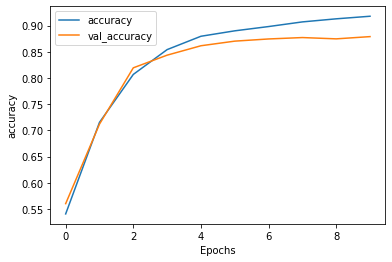

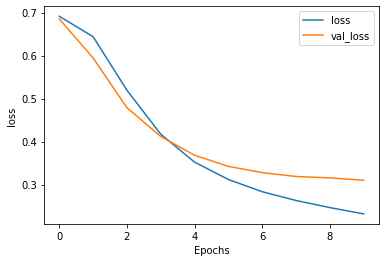

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(hist, string):
  plt.plot(hist.history[string])
  plt.plot(hist.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(hist, 'accuracy')
plot_graphs(hist, 'loss')
#subword로 했을 때 성능 좋아짐

LSTM

In [29]:
from tensorflow.keras.layers import LSTM

model = Sequential([
                    Embedding(tokenizer.vocab_size, embedding_dim),
                    LSTM(64),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#sequence_length: None -> 입력size 얼마나 들어오든 다 받겠다

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          130960    
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 153,809
Trainable params: 153,809
Non-trainable params: 0
_________________________________________________________________


In [30]:
hist = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 498s 1s/step - loss: 0.6933 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5001
Epoch 2/10
391/391 [==============================] - 478s 1s/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 3/10
391/391 [==============================] - 477s 1s/step - loss: 0.6928 - accuracy: 0.5025 - val_loss: 0.6929 - val_accuracy: 0.5026
Epoch 4/10
391/391 [==============================] - 479s 1s/step - loss: 0.6921 - accuracy: 0.5050 - val_loss: 0.6930 - val_accuracy: 0.4998
Epoch 5/10
391/391 [==============================] - 478s 1s/step - loss: 0.6905 - accuracy: 0.5009 - val_loss: 0.6939 - val_accuracy: 0.5011
Epoch 6/10
391/391 [==============================] - 502s 1s/step - loss: 0.6894 - accuracy: 0.5066 - val_loss: 0.6948 - val_accuracy: 0.4997
Epoch 7/10
391/391 [==============================] - 482s 1s/step - loss: 0.6920 - accuracy: 0.5038 - val_loss: 0.6944 - val_accuracy: 0.5022

RNN

In [31]:
from tensorflow.keras.layers import SimpleRNN

model = Sequential([
                    Embedding(tokenizer.vocab_size, embedding_dim),
                    SimpleRNN(64),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          130960    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                5184      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 138,257
Trainable params: 138,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
hist = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 223s 565ms/step - loss: 0.6943 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/10
391/391 [==============================] - 209s 534ms/step - loss: 0.6938 - accuracy: 0.4965 - val_loss: 0.6948 - val_accuracy: 0.5001
Epoch 3/10
391/391 [==============================] - 210s 536ms/step - loss: 0.6956 - accuracy: 0.5048 - val_loss: 0.7007 - val_accuracy: 0.5024
Epoch 4/10
391/391 [==============================] - 210s 536ms/step - loss: 0.6981 - accuracy: 0.5014 - val_loss: 0.6956 - val_accuracy: 0.4995
Epoch 5/10
391/391 [==============================] - 213s 544ms/step - loss: 0.6958 - accuracy: 0.4980 - val_loss: 0.6966 - val_accuracy: 0.4963
Epoch 6/10
391/391 [==============================] - 209s 533ms/step - loss: 0.6957 - accuracy: 0.5014 - val_loss: 0.6962 - val_accuracy: 0.5012
Epoch 7/10
391/391 [==============================] - 211s 538ms/step - loss: 0.6942 - accuracy: 0.5038 - val_loss: 0.6939 -

Bidirectional

In [34]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
                    Embedding(tokenizer.vocab_size, embedding_dim),
                    Bidirectional(LSTM(64)),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 857s 2s/step - loss: 0.5560 - accuracy: 0.6963 - val_loss: 0.4451 - val_accuracy: 0.8235
Epoch 2/10
391/391 [==============================] - 840s 2s/step - loss: 0.3402 - accuracy: 0.8626 - val_loss: 0.5607 - val_accuracy: 0.7038
Epoch 3/10
391/391 [==============================] - 849s 2s/step - loss: 0.3135 - accuracy: 0.8775 - val_loss: 0.4686 - val_accuracy: 0.8073
Epoch 4/10
391/391 [==============================] - 840s 2s/step - loss: 0.2878 - accuracy: 0.8883 - val_loss: 0.3846 - val_accuracy: 0.8445
Epoch 5/10
391/391 [==============================] - 836s 2s/step - loss: 0.2306 - accuracy: 0.9138 - val_loss: 0.4818 - val_accuracy: 0.8155
Epoch 6/10
391/391 [==============================] - 839s 2s/step - loss: 0.1784 - accuracy: 0.9371 - val_loss: 0.4638 - val_accuracy: 0.8518
Epoch 7/10
391/391 [==============================] - 838s 2s/step - loss: 0.1701 - accuracy: 0.9399 - val_loss: 0.4726 - val_accuracy: 0.8271

Stacking - 여러 층 쌓기

In [ ]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
                    Embedding(tokenizer.vocab_size, embedding_dim),
                    Bidirectional(LSTM(64, return_sequences=True)),
                    Bidirectional(LSTM(64)),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

GRU - 속도 좀더 빠름

In [ ]:
from tensorflow.keras.layers import GRU

model = Sequential([
                    Embedding(tokenizer.vocab_size, embedding_dim),
                    GRU(64),
                    Dense(32, activation='relu'),
                    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()